<a href="https://colab.research.google.com/github/heghiw/credit-score/blob/main/creditscore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement **



You are working as a data scientist in a global finance company. Over the years, the company has collected basic bank details and gathered a lot of credit-related information. The management wants to build an intelligent system to segregate the people into credit score brackets to reduce the manual efforts.

Task
Given a person’s credit-related information, build a machine learning model that can classify the credit score.

imports

In [96]:
from pyspark.sql import SparkSession
import kagglehub
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.functions import col
from functools import reduce  # import reduce function
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, DoubleType

data

In [81]:
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

100%|██████████| 9.51M/9.51M [00:00<00:00, 84.8MB/s]

Extracting files...


In [82]:
# create spark session
spark = SparkSession.builder \
    .appName("CreditScoreClassification") \
    .getOrCreate()

# read the dataset
df = spark.read.csv(path, header=True, inferSchema=True)

# show the first 5 rows
df.show(5)


+------+-----------+--------+-------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|         Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------+----+-----------+------

# **Block 1 **
 **Data Cleaning and Exploration**

## 1.1
Duplicites, missing values

In [103]:
# calculate missing values for each column (both absolute and percentage)
missing_data = [
    (
        column,
        df.filter(df[column].isNull()).count(),
        (df.filter(df[column].isNull()).count() / df.count()) * 100 if df.count() != 0 else 0
    )
    for column in df.columns
]


missing_df = spark.createDataFrame(missing_data, ["Column", "Missing_Values_Absolute", "Missing_Values_Percentage"])


missing_df.show(missing_df.count(), truncate=False)


+------------------------+-----------------------+-------------------------+
|Column                  |Missing_Values_Absolute|Missing_Values_Percentage|
+------------------------+-----------------------+-------------------------+
|ID                      |0                      |0.0                      |
|Customer_ID             |0                      |0.0                      |
|Month                   |0                      |0.0                      |
|Name                    |15000                  |10.0                     |
|Age                     |7416                   |4.944                    |
|SSN                     |0                      |0.0                      |
|Occupation              |0                      |0.0                      |
|Annual_Income           |10500                  |7.000000000000001        |
|Monthly_Inhand_Salary   |22500                  |15.0                     |
|Num_Bank_Accounts       |0                      |0.0                      |

In [89]:
# count the number of duplicate rows
duplicates = df.subtract(df.dropDuplicates())

num_duplicates = duplicates.count()

print(f"Number of duplicate rows: {num_duplicates}")


Number of duplicate rows: 0


target leakage

In [104]:
# Checking for features that could be related to target leakage
target_variable = "Credit_Score"

# List of columns (features) in the dataset
feature_columns = df.columns

# Drop the target variable from the list of feature columns
feature_columns = [col for col in feature_columns if col != target_variable]

# Displaying the features to manually check for potential leakage
print("Feature columns (excluding the target variable):")
print(feature_columns)

# Examine the correlation between features and the target variable (Credit_Score)
correlation_data = []

for column in feature_columns:
    # Correlation of each feature with the target variable (credit score)
    if df.select(column).dtypes[0][1] == 'string':
        # String columns are excluded from correlation analysis
        continue
    corr_value = df.stat.corr(column, target_variable)
    correlation_data.append((column, corr_value))

# Convert correlation data into a DataFrame for readability
correlation_df = spark.createDataFrame(correlation_data, ["Feature", "Correlation_with_Target"])
correlation_df.show(truncate=False)


Feature columns (excluding the target variable):
['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance']


IllegalArgumentException: requirement failed: Currently correlation calculation for columns with dataType string not supported.

## 1.2
Exploratory analysis, data types, distribution

typecast

In [100]:


df = df.withColumn("ID", col("ID").cast(StringType())) \
       .withColumn("Customer_ID", col("Customer_ID").cast(StringType())) \
       .withColumn("Month", col("Month").cast(StringType())) \
       .withColumn("Name", col("Name").cast(StringType())) \
       .withColumn("Age", col("Age").cast(IntegerType())) \
       .withColumn("SSN", col("SSN").cast(StringType())) \
       .withColumn("Occupation", col("Occupation").cast(StringType())) \
       .withColumn("Annual_Income", col("Annual_Income").cast(IntegerType())) \
       .withColumn("Monthly_Inhand_Salary", col("Monthly_Inhand_Salary").cast(IntegerType())) \
       .withColumn("Num_Bank_Accounts", col("Num_Bank_Accounts").cast(IntegerType())) \
       .withColumn("Num_Credit_Card", col("Num_Credit_Card").cast(IntegerType())) \
       .withColumn("Interest_Rate", col("Interest_Rate").cast(DoubleType())) \
       .withColumn("Num_of_Loan", col("Num_of_Loan").cast(IntegerType())) \
       .withColumn("Type_of_Loan", col("Type_of_Loan").cast(StringType())) \
       .withColumn("Delay_from_due_date", col("Delay_from_due_date").cast(IntegerType())) \
       .withColumn("Num_of_Delayed_Payment", col("Num_of_Delayed_Payment").cast(IntegerType())) \
       .withColumn("Changed_Credit_Limit", col("Changed_Credit_Limit").cast(DoubleType())) \
       .withColumn("Num_Credit_Inquiries", col("Num_Credit_Inquiries").cast(IntegerType())) \
       .withColumn("Credit_Mix", col("Credit_Mix").cast(StringType())) \
       .withColumn("Outstanding_Debt", col("Outstanding_Debt").cast(DoubleType())) \
       .withColumn("Credit_Utilization_Ratio", col("Credit_Utilization_Ratio").cast(DoubleType())) \
       .withColumn("Credit_History_Age", col("Credit_History_Age").cast(StringType())) \
       .withColumn("Payment_of_Min_Amount", col("Payment_of_Min_Amount").cast(StringType())) \
       .withColumn("Total_EMI_per_month", col("Total_EMI_per_month").cast(DoubleType())) \
       .withColumn("Amount_invested_monthly", col("Amount_invested_monthly").cast(DoubleType())) \
       .withColumn("Payment_Behaviour", col("Payment_Behaviour").cast(StringType())) \
       .withColumn("Monthly_Balance", col("Monthly_Balance").cast(DoubleType())) \
       .withColumn("Credit_Score", col("Credit_Score").cast(StringType()))



In [101]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: integer (nullable = true)
 |-- Monthly_Inhand_Salary: integer (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: integer (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable =

In [105]:
# get list of categorical columns (excluding 'ID')
categorical_columns = [col_name for col_name, dtype in df.dtypes if dtype == "string" ]

print("Unique values in categorical columns:")
for col_name in categorical_columns:
    # get unique values for the column
    unique_values = df.select(col_name).distinct()
    unique_count = unique_values.count()

    # print unique values only if there are less than 20 unique values
    if unique_count < 20:
        unique_list = unique_values.rdd.flatMap(lambda x: x).collect()  # collect unique values
        print(f"{col_name}: {unique_count} unique values")
        print(f"Values: {unique_list}")
    else:
        print(f"{col_name}: {unique_count} unique values (too many to list)")


Unique values in categorical columns:
ID: 150000 unique values (too many to list)
Customer_ID: 12500 unique values (too many to list)
Month: 12 unique values
Values: ['July', 'February', 'January', 'March', 'May', 'August', 'April', 'June', 'November', 'October', 'December', 'September']
Name: 10140 unique values (too many to list)
SSN: 12501 unique values (too many to list)
Occupation: 16 unique values
Values: ['Scientist', 'Media_Manager', 'Musician', 'Lawyer', 'Teacher', 'Developer', 'Writer', 'Architect', 'Mechanic', 'Entrepreneur', 'Journalist', 'Doctor', 'Engineer', 'Accountant', 'Manager', '_______']
Type_of_Loan: 6261 unique values (too many to list)
Credit_Mix: 4 unique values
Values: ['_', 'Good', 'Bad', 'Standard']
Credit_History_Age: 1 unique values
Values: [None]
Payment_of_Min_Amount: 3 unique values
Values: ['NM', 'No', 'Yes']
Payment_Behaviour: 7 unique values
Values: ['Low_spent_Small_value_payments', 'High_spent_Medium_value_payments', 'High_spent_Small_value_payments

In [106]:
# get basic statistics for numerical columns
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ["int", "double"]]
print("Basic statistics for numerical columns:")
df.select(numerical_columns).describe().show()

print("Basic statistics for categorical columns:")
for col_name in categorical_columns:
    # count occurrences of each unique value in the column
    value_counts = df.groupBy(col_name).count().orderBy('count', ascending=False)
    print(f"\nStatistics for {col_name}:")
    value_counts.show()

Basic statistics for numerical columns:
+-------+------------------+------------------+---------------------+------------------+------------------+-----------------+-----------------+-------------------+----------------------+--------------------+--------------------+------------------+------------------------+-------------------+-----------------------+--------------------+
|summary|               Age|     Annual_Income|Monthly_Inhand_Salary| Num_Bank_Accounts|   Num_Credit_Card|    Interest_Rate|      Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|  Outstanding_Debt|Credit_Utilization_Ratio|Total_EMI_per_month|Amount_invested_monthly|     Monthly_Balance|
+-------+------------------+------------------+---------------------+------------------+------------------+-----------------+-----------------+-------------------+----------------------+--------------------+--------------------+------------------+------------------------+------------

In [107]:
# recheck data types of all columns
print("Data types of columns:")
for col_name, dtype in df.dtypes:
    print(f"{col_name}: {dtype}")


Data types of columns:
ID: string
Customer_ID: string
Month: string
Name: string
Age: int
SSN: string
Occupation: string
Annual_Income: int
Monthly_Inhand_Salary: int
Num_Bank_Accounts: int
Num_Credit_Card: int
Interest_Rate: double
Num_of_Loan: int
Type_of_Loan: string
Delay_from_due_date: int
Num_of_Delayed_Payment: int
Changed_Credit_Limit: double
Num_Credit_Inquiries: int
Credit_Mix: string
Outstanding_Debt: double
Credit_Utilization_Ratio: double
Credit_History_Age: string
Payment_of_Min_Amount: string
Total_EMI_per_month: double
Amount_invested_monthly: double
Payment_Behaviour: string
Monthly_Balance: double
Credit_Score: string


graphs

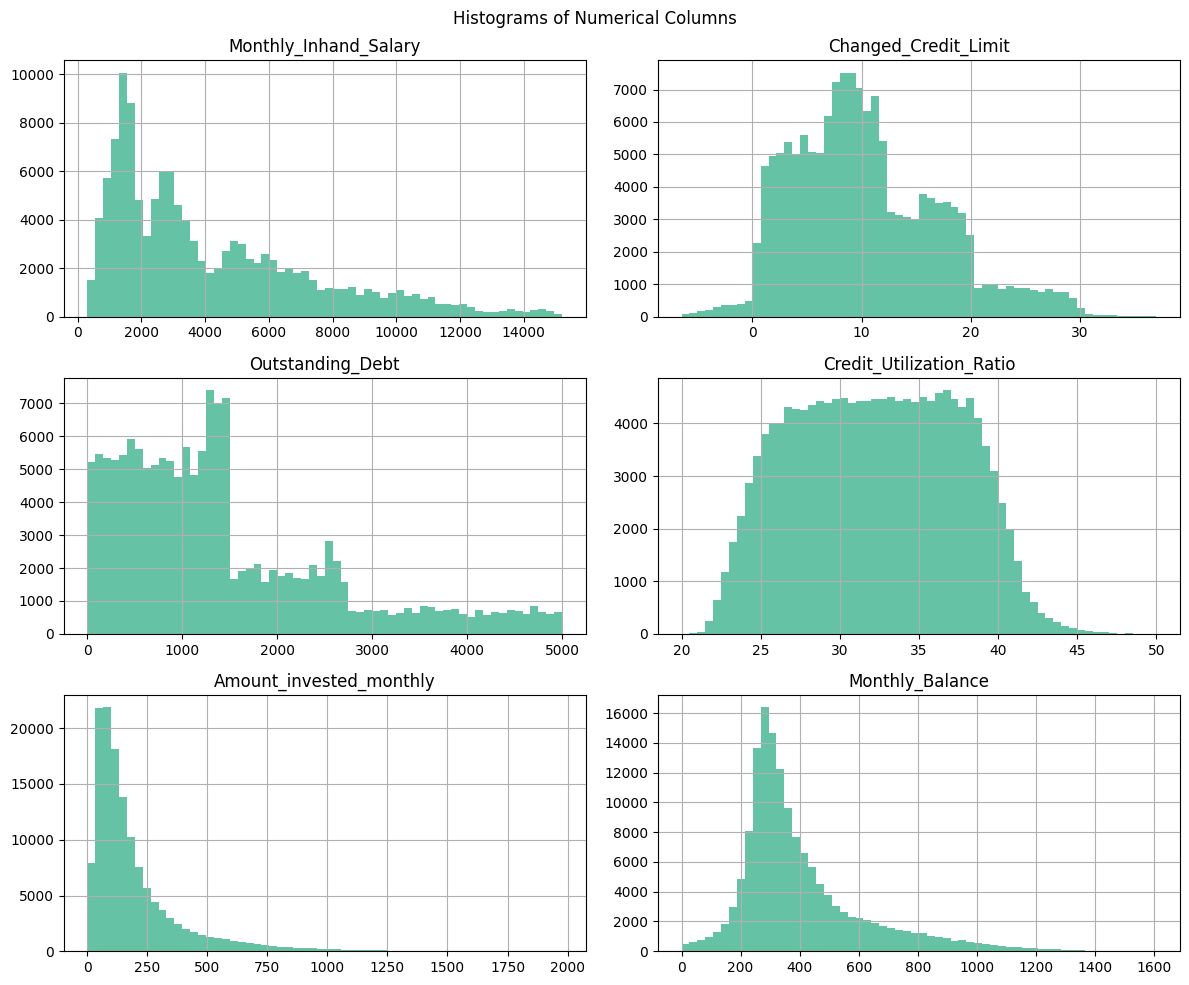

In [113]:
exclude_columns = [
    "Age", "Annual_Income", "Num_Bank_Accounts", "Num_Credit_Card",
    "Interest_Rate", "Num_of_Loan", "Delay_from_due_date",
    "Num_of_Delayed_Payment", "Num_Credit_Inquiries", "Total_EMI_per_month"
]

# Get numerical columns excluding the specified ones
hist_data = [col_name for col_name, dtype in df.dtypes
             if dtype in ["int", "double"] and col_name not in exclude_columns]

# Convert the selected numerical columns to pandas DataFrame
df_pandas = df.select(hist_data).toPandas()

# Plot histograms for each numerical column
df_pandas.hist(bins=60, figsize=(12, 10))
plt.suptitle('Histograms of Numerical Columns')
plt.tight_layout()
plt.show()

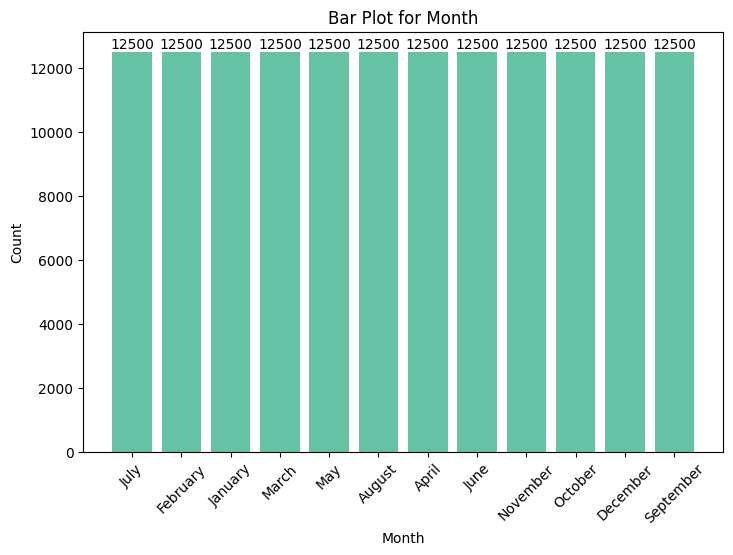

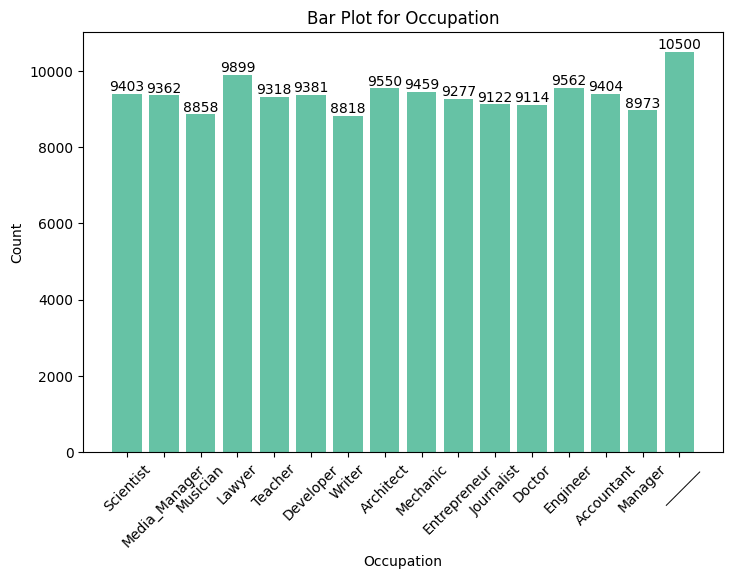

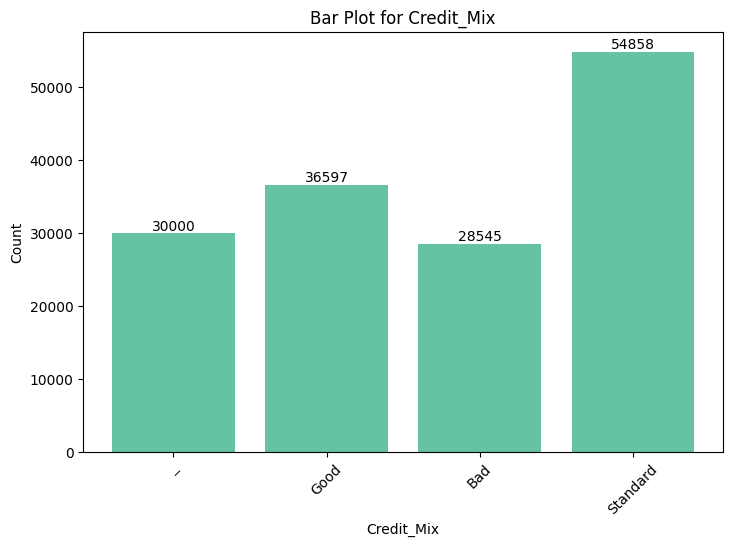

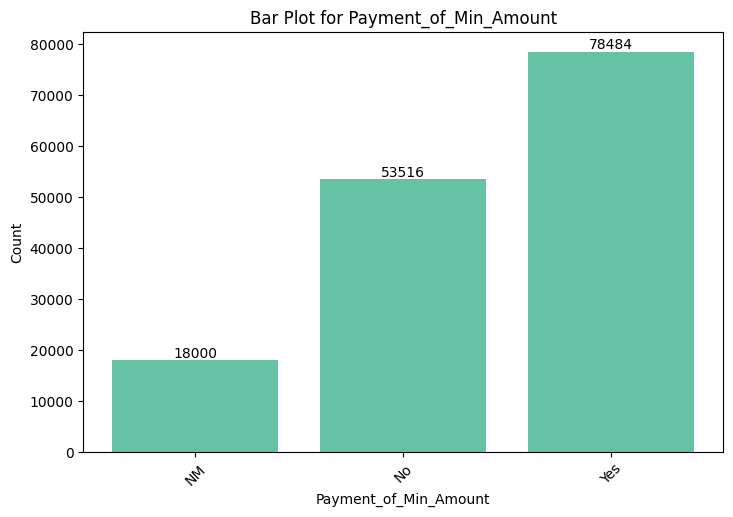

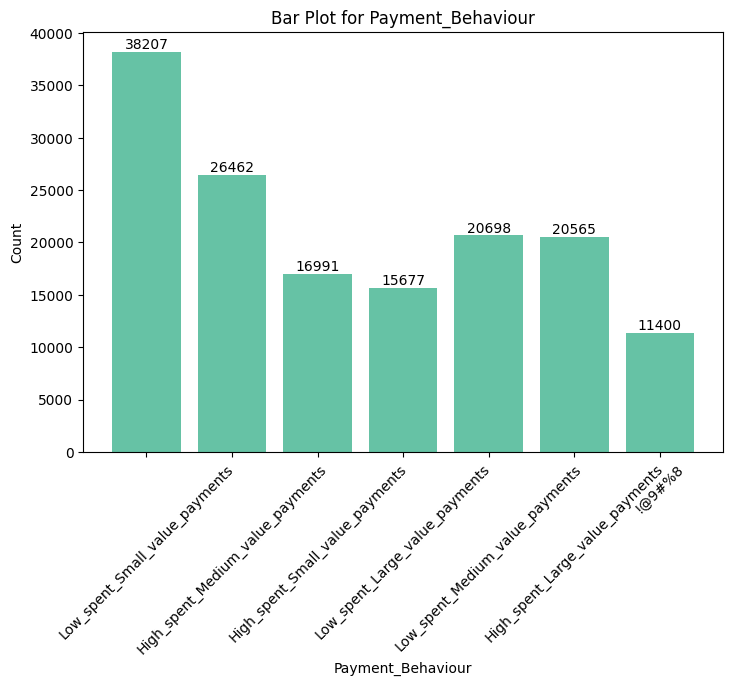

TypeError: 'value' must be an instance of str or bytes, not a None

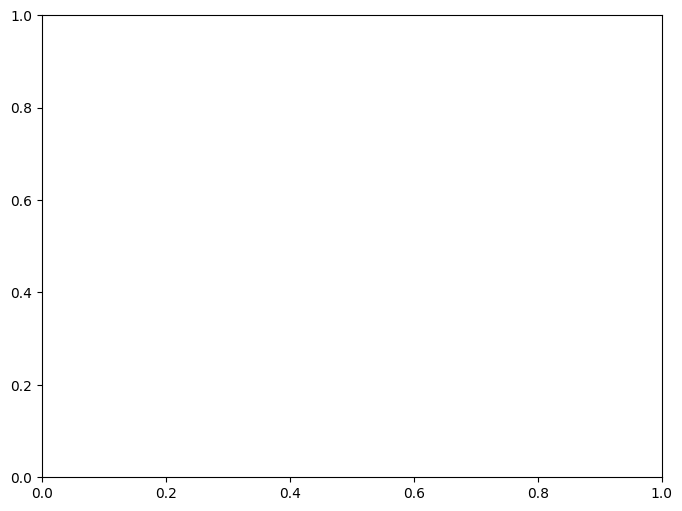

In [115]:
import seaborn as sns
sns.set_palette("Set2")

# loop through categorical columns and plot bar plots for those with less than 20 unique values and more than 1 unique value
for col_name in categorical_columns:
    # count unique values for each categorical column if >1 and <20
    unique_count = df.select(col_name).distinct().count()

    if unique_count > 1 and unique_count < 20:
        value_counts = df.groupBy(col_name).count().toPandas()

        # plot bar plot
        plt.figure(figsize=(8, 6))
        bars = plt.bar(value_counts[col_name], value_counts['count'])

        # annotate each bar with the count value on top
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

        plt.title(f"Bar Plot for {col_name}")
        plt.xlabel(col_name)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.subplots_adjust(bottom=0.2, left=0.15, right=0.95, top=0.9)
        plt.show()


## 1.3
Further cleaning the data [nulls were deleted during the previous steps]

In [79]:
df_f = df.drop("SSN", "Loan Title") #

In [80]:
df.show(5)

+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+--------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|          Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Intere